In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from copy import deepcopy 
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
np.random.seed(100)

### Solution using CVX

In [2]:
def generate_params(size):
    mu = np.linspace(0.05,0.50,size)
    sigma = np.diag(mu+0.05)**2
    for i in range(size):
        for j in range(i+1, size):
            sigma[i][j] = 0.35 * np.sqrt(sigma[i][i]*sigma[j][j])
            sigma[j][i] = sigma[i][j]
    return mu, sigma

beta = 5
lamda = 0.1

size = 3
mu = np.array([0.13,0.1,0.08])
sigma = np.array([[0.05,0.004,0.0002],[0.004,0.01,-0.0005],[0.0002,-0.0005,0.001]])
R = 0.1

# size = 10
# mu, sigma = generate_params(size)
# R = 0.4
def sr(x,mu,sigma,beta,lamda):
    return -np.dot(mu,x) + beta/2 * np.matmul(np.matmul(x,sigma),x) - np.log(lamda)/beta

def get_optimal_ubsr(mu=mu,sigma=sigma,R=R,beta=beta,lamda=lamda):
    x = cp.Variable(size)

    # Define the objective function
    objective = -mu @ x + (beta / 2) * cp.quad_form(x, sigma) - cp.log(lamda) / beta

    # Define the constraints
    constraints = [sum(x) <= 1] + [x[i]>=0 for i in range(size)] + [mu.T @ x >= R]

    # Formulate the optimization problem
    problem = cp.Problem(cp.Minimize(objective), constraints)

    # Solve the problem
    problem.solve(solver='OSQP', max_iter=10000)
    
    if problem.status == cp.OPTIMAL:
        ubsr = -mu @ x.value + beta/2 * x.value.T @ sigma @ x.value - np.log(lamda)/beta
        return [ubsr,np.abs(np.round(x.value,5)),round(mu @ x.value,4)]
    else:
        print("Optimization problem did not converge.")
        
get_optimal_ubsr()

[0.3735830503848838, array([0.21948, 0.45131, 0.32921]), 0.1]

In [3]:
print(mu)

[0.13 0.1  0.08]


In [4]:
print(sigma)

[[ 0.05    0.004   0.0002]
 [ 0.004   0.01   -0.0005]
 [ 0.0002 -0.0005  0.001 ]]


### Analytical Solution

In [5]:
a = np.matmul(np.matmul(mu,np.linalg.inv(sigma)),np.ones(size).reshape(-1,1))[0]
b = np.matmul(np.matmul(np.ones(size),np.linalg.inv(sigma)),np.ones(size).reshape(-1,1))[0]
c = np.matmul(np.matmul(np.ones(size),np.linalg.inv(sigma)),mu.reshape(-1,1))[0]
d = np.matmul(np.matmul(mu,np.linalg.inv(sigma)),mu.reshape(-1,1))[0]
lambda1 = beta*(a - R*b) / (a*c - b*d) - 1
lambda2 = beta*(R*c - d) / (a*c - b*d)

In [6]:
theta_star = ((1+lambda1)*np.matmul(np.linalg.inv(sigma),mu.reshape(-1,1)) + lambda2 * np.matmul(np.linalg.inv(sigma),np.ones(size).reshape(-1,1)))/beta
theta_star = theta_star.flatten()

In [7]:
theta_star

array([0.21947528, 0.45131181, 0.32921292])

In [8]:
sr_star = sr(theta_star, mu, sigma, beta, lamda)
sr_star

0.37358305038488443

### Solution using SGD

In [9]:
def returns(mu, sig):
    return np.random.multivariate_normal(mean = mu, cov = sig)

def returns_m(mu, sig, m):
    return np.random.multivariate_normal(mean = mu, cov = sig, size = m)

def loss_dash(x, beta):
    return -beta*np.exp(beta*x)

def estimate_h(beta, theta, sr, returns):
    loss_dashes = loss_dash(-np.matmul(theta,returns.T)-sr,beta)
    B_m = np.sum(loss_dashes)
    A_m = np.matmul(loss_dashes.T,-returns)
    h = A_m/B_m                                                                                                                             
    return h

def get_alpha_k(n,k,alpha0):
        i = int(np.ceil(np.log2(n)) - np.ceil(np.log2(n-k)))
        return alpha0/np.sqrt(n) * 2**(-i)

In [122]:
get_alpha_k(500,495,50)

0.034938562148434216

In [10]:
def loss(x,beta=beta):
    return np.exp(beta*x)

def get_xi(theta,return_samples):
    xi_vec = -np.matmul(theta,return_samples.T)
    return xi_vec

def estimate_sr(theta,return_samples):
    tl = 0
    tu = 1
    t0 = 0.5
    t = deepcopy(t0)
    c = 100
    xi_vec = get_xi(theta,return_samples)
    k = 1
    for xi in xi_vec:
        g_hat = loss(xi-t) - lamda
        t = t + c/k * g_hat
        k += 1
        t = min(max(t,tl),tu)
    return t


### Convex Case

In [179]:
Thetas1 = []
SRs1 = []
alpha0 = 10
m = 100
n = 1000
np.random.seed(101)
for it in tqdm(range(100)):
    theta_vals = []
    sr_estimates = []
    theta_init = np.random.uniform(0,1,3)
    theta_init = theta_init/np.sum(theta_init)
    theta_vals.append(deepcopy(theta_init))
    return_samples = []
    theta = deepcopy(theta_init)
    return_samples = returns_m(mu, sigma, m)
    
    for k in range(n):
        if k>0 and k<20:
            r_samples = returns_m(mu, sigma, m)
            return_samples = np.concatenate((return_samples,r_samples),axis=0)
        elif k==0:
            return_samples = r_samples    
        sr_val = estimate_sr(theta/np.sum(theta),return_samples[:2000])
        r_i = np.mean(return_samples, axis = 0)
        estimate = estimate_h(beta, theta, sr_val, return_samples)

        alpha = get_alpha_k(n,k,alpha0)
        j = np.random.choice([0,1,2])
        theta[j] = theta[j] - alpha * (estimate[j] - lambda1 * r_i[j] - lambda2)
        if theta[j] < 0:
            theta[j] = 0

        theta_vals.append(theta/np.sum(theta))
        sr_estimates.append(sr_val)
        
    Thetas1.append(theta_vals)
    SRs1.append(sr_estimates)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.47s/it]


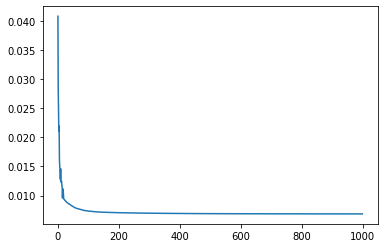

In [220]:
plt.plot(np.mean(np.abs(np.array(SRs1)-sr_star),axis=0))

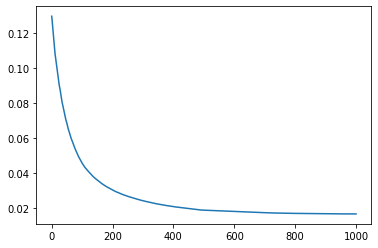

In [226]:
Theta_Errors = []
for j in range(100):
    theta_error = []
    for i in range(len(Thetas1[j])):
        theta_error.append(np.sum((Thetas1[j][i]-theta_star)**2))
    Theta_Errors.append(theta_error)
    
plt.plot(np.mean(np.array(Theta_Errors),axis=0))

In [210]:
df = pd.DataFrame(np.mean(np.abs(np.array(SRs1)-sr_star),axis=0).reshape(-1,1),columns=['|ubsr - ubsr*|'])
df.to_csv("markowitz_ubsr_error_convex_case.csv")

In [211]:
df = pd.DataFrame(np.mean(np.array(Theta_Errors),axis=0).reshape(-1,1),columns=['|Theta - Theta*|^2'])
df.to_csv("markowitz_theta_error_squared_convex_case.csv")

In [182]:
np.mean(np.array(Thetas1)[:,-1,:],axis=0)

array([0.22060688, 0.46338056, 0.31601256])

In [227]:
np.std(np.array(Theta_Errors),axis=0)[-1]

0.0217614169631516

In [217]:
np.std(np.abs(np.array(SRs1)-sr_star),axis=0)[-1]

0.005544173552639107

In [221]:
np.mean(SRs1,axis=0)[-1]

0.37340525280654646

In [218]:
np.std(SRs1,axis=0)[-1]

0.008807145058759696

### Strongly Convex Case

In [212]:
Thetas2 = []
SRs2 = []
c = 50
m = 100
n = 1000
np.random.seed(101)

for it in tqdm(range(100)):
    theta_vals = []
    sr_estimates = []
    theta_init = np.random.uniform(0,1,3)
    theta_init = theta_init/np.sum(theta_init)
    theta_vals.append(deepcopy(theta_init))
    return_samples = []
    theta = deepcopy(theta_init) 
    return_samples = returns_m(mu, sigma, m)
    for k in range(n):
        if k>0 and k<20:
            r_samples = returns_m(mu, sigma, m)
            return_samples = np.concatenate((return_samples,r_samples),axis=0)
        elif k==0:
            return_samples = r_samples    
        sr_val = estimate_sr(theta/np.sum(theta),return_samples[:2000])
        r_i = np.mean(return_samples, axis = 0)
        estimate = estimate_h(beta, theta, sr_val, return_samples)

        alpha = c/(c+k)
        j = np.random.choice([0,1,2])
        theta[j] = theta[j] - alpha * (estimate[j] - lambda1 * r_i[j] - lambda2)
        if theta[j] < 0:
            theta[j] = 0
        theta_vals.append(theta/np.sum(theta))
        sr_estimates.append(sr_val)
        
    Thetas2.append(theta_vals)
    SRs2.append(sr_estimates)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:32<00:00,  3.92s/it]


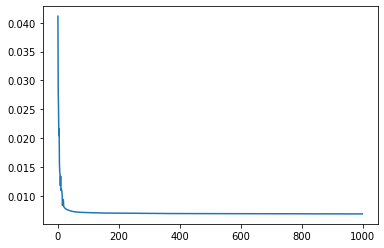

In [213]:
plt.plot(np.mean(np.abs(np.array(SRs2)-sr_star),axis=0))

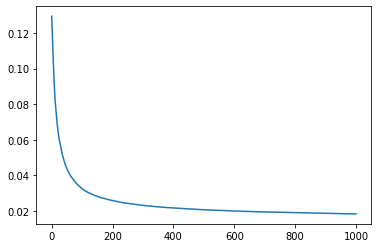

In [224]:
Theta_Errors = []
for j in range(100):
    theta_error = []
    for i in range(len(Thetas2[j])):
        theta_error.append(np.sum((Thetas2[j][i]-theta_star)**2))
    Theta_Errors.append(theta_error)
    
plt.plot(np.mean(np.array(Theta_Errors),axis=0))

In [215]:
df = pd.DataFrame(np.mean(np.abs(np.array(SRs2)-sr_star),axis=0).reshape(-1,1),columns=['|ubsr - ubsr*|'])
df.to_csv("markowitz_ubsr_error_strongly_convex_case.csv")

In [216]:
df = pd.DataFrame((np.mean(np.array(Theta_Errors),axis=0)).reshape(-1,1),columns=['|Theta - Theta*|^2'])
df.to_csv("markowitz_theta_error_squared_strongly_convex_case.csv")

In [190]:
np.mean(np.array(Thetas2)[:,-1,:],axis=0)

array([0.24481511, 0.44474503, 0.31043986])

In [222]:
np.mean(SRs2,axis=0)[-1]

0.3734904323852629

In [225]:
np.std(np.array(Theta_Errors),axis=0)[-1]

0.02324917854942634

In [228]:
np.std(np.abs(np.array(SRs2)-sr_star),axis=0)[-1]

0.005615570170628716